## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
from joblib import dump, load
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import preprocessing as pp
import neural_net as n_n

## Loading Data

In [16]:
my_path = '/Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/cubic_F_225_v3'
my_loaded_data = pp.load_data(my_path)


>> Retrieving: cubic_F_225_v3_regression_3000.joblib
>> Retrieving: cubic_F_225_v3_labels_classification_system_3000.joblib
>> Retrieving: cubic_F_225_v3_features_3000.joblib
>> Retrieving: cubic_F_225_v3_labels_classification_space_3000.joblib
>> Retrieving: cubic_F_225_v3_labels_classification_bravais_3000.joblib
>> Retrieving: cubic_F_225_v3_material_ids3000.joblib
>> Sanity Check: printing element(s) 1 of 3000 from each array

>> [[5.26, 5.26, 5.26, 60.0, 60.0, 60.0]]
>> ['Cubic']
>> [[3.59, 2.539, 5.077, 3.59, 2.539, 0.785, 0.0, 0.786, 0.785, 3.59, 4.397, 2.538, 5.077, 4.397, 0.615, 0.956, 0.0, 0.955, 3.59, 2.539, 3.59, 2.539, 5.077, 0.785, 0.786, 0.785, 0.0, 3.59, 4.397, 2.538, 5.077, 4.397, 0.615, 0.956, 0.0, 0.955, 3.59, 4.397, 2.538, 5.077, 4.397, 0.615, 0.956, 0.0, 0.955, 3.59, 2.539, 5.077, 3.59, 2.539, 0.785, 0.0, 0.786, 0.785]]
>> [225]
>> ['F']
>> [(MPID(mp-1038831), 'Mg3Bi')]


In [17]:
print(len(my_loaded_data[4]))

3000


In [18]:
no_angles_regression = []

## Filter through side lengths only
for element in my_loaded_data[0]:
    no_angles_regression.append(element[:1])

train_data, val_data, test_data = n_n.dataset_split(
    my_loaded_data[2], no_angles_regression)

## Architecture

In [6]:
class my_network(nn.Module):
    def __init__(self, sz=[64, 100, 128], inp=54, out=1):
        super(my_network, self).__init__()
        self.layer_sizes = [inp] + sz + [out]
        self.name = "layer4linear"

        self.fc1 = nn.Linear(inp, sz[0])
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(sz[0], sz[1])
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(sz[1], sz[2])
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(sz[2], out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def get_number_params(self):
        num_params = 0
        for i in range(len(self.layer_sizes)-1):
            num_params += self.layer_sizes[i] * \
                self.layer_sizes[i+1] + self.layer_sizes[i+1]
        return num_params

test = my_network()
print(test.get_number_params())

23077


## Training

_______________________Epoch 40_______________________
Train loss: 0.723829798710843 | Validation loss: 0.9756216323324318 
Finished Training
Total time elapsed: 2.85 seconds


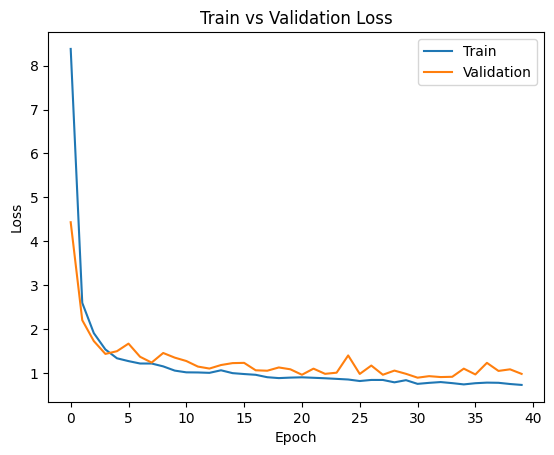

(0.723829798710843, 0.9756216323324318)

In [21]:
model = my_network()
n_n.train_regression(
      model, 
      train_data, 
      val_data,
      batch_size=16, 
      learning_rate=0.0009, 
      num_epochs=40, 
      checkpoints=False,
      save_model=True 
      )

Test Loss: 0.02777486522992452
GT:  8.55    PD:  7.89    DIFF:  0.66    %DIFF:  7.72%
GT:  4.56    PD:  4.40    DIFF:  0.16    %DIFF:  3.51%
GT:  8.06    PD:  7.46    DIFF:  0.60    %DIFF:  7.44%
GT:  5.06    PD:  4.75    DIFF:  0.31    %DIFF:  6.13%
GT:  4.78    PD:  4.53    DIFF:  0.25    %DIFF:  5.23%
GT:  4.57    PD:  4.40    DIFF:  0.17    %DIFF:  3.72%
GT:  8.64    PD:  5.37    DIFF:  3.27    %DIFF: 37.85%
GT:  4.73    PD:  4.49    DIFF:  0.24    %DIFF:  5.07%
GT:  8.12    PD:  8.29    DIFF: -0.17    %DIFF:  2.09%
GT:  4.10    PD:  3.99    DIFF:  0.11    %DIFF:  2.68%
GT:  4.47    PD:  4.34    DIFF:  0.13    %DIFF:  2.91%
GT:  4.76    PD:  4.58    DIFF:  0.18    %DIFF:  3.78%
GT:  4.99    PD:  4.84    DIFF:  0.15    %DIFF:  3.01%
GT:  5.35    PD:  5.12    DIFF:  0.23    %DIFF:  4.30%
GT:  4.77    PD:  4.52    DIFF:  0.25    %DIFF:  5.24%
GT:  6.24    PD:  6.21    DIFF:  0.03    %DIFF:  0.48%
GT:  4.89    PD:  4.73    DIFF:  0.16    %DIFF:  3.27%
GT:  4.76    PD:  4.60    DIFF:  0

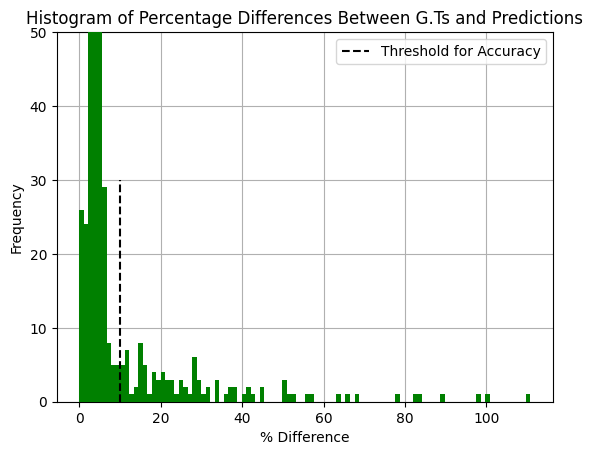

In [22]:
n_n.testing(model, test_data)